# Polygonal Map Generation using Voronoi Maps

See Design.org for the research. Minimal description here as we develop the
  idea.

First step is to recreate the [tutorial](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/spatial.html) on using SciPy's spatial data structures
and algorithms.

In [2]:
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
points = np.array([[0., 0.], [0., 1.], [0., 2.], [1., 0.], [1., 1.], [1., 2.],
                   [2., 0.], [2., 1.], [2., 2.]])

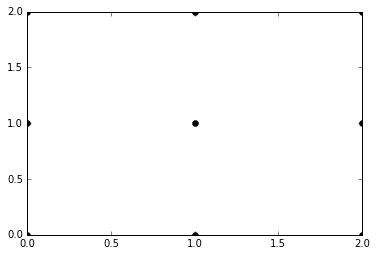

In [4]:
plt.plot(points[:,0], points[:,1], 'ko')
plt.show()

In [5]:
vor = Voronoi(points)
vor.vertices

array([[ 0.5,  0.5],
       [ 1.5,  0.5],
       [ 0.5,  1.5],
       [ 1.5,  1.5]])

The values in `vor.regions` denote the set of points from `vor.vertices` forming
the Polygonal edges of the Voronoi regions. Negative numbers indicate points at
infinity.

In [6]:
vor.regions

[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [3, 2, 0, 1],
 [2, -1, 0],
 [3, -1, 1]]

`vor.ridge_vertices` indicate lines in 2-D that separate the regions. Voronoi
ridges are perpendicular to lines drawn between the input points.
`vor.ridge_points` are the two points each ridge corresponds to.

In [7]:
vor.ridge_points

array([[0, 1],
       [0, 3],
       [6, 3],
       [6, 7],
       [3, 4],
       [5, 8],
       [5, 2],
       [5, 4],
       [8, 7],
       [2, 1],
       [4, 1],
       [4, 7]], dtype=int32)

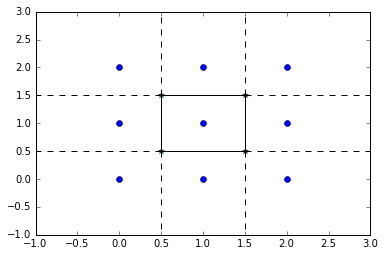

In [8]:
plt.plot(points[:,0], points[:, 1], 'o')
plt.plot(vor.vertices[:,0], vor.vertices[:,1], '*')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
# Draw edges while avoiding points at infinity
for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-')

# Special care for the lines extending to infinity
center = points.mean(axis=0)
for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
    simplex = np.asarray(simplex)
    if np.any(simplex < 0):
        i = simplex[simplex >= 0][0]
        t = points[pointidx[1]] - points[pointidx[0]] # tangent
        t /= np.linalg.norm(t)
        n = np.array([-t[1], t[0]]) # Normal
        midpoint = points[pointidx].mean(axis=0)
        far_point = vor.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
        plt.plot([vor.vertices[i,0], far_point[0]],
                 [vor.vertices[i, 1], far_point[1]], 'k--')
plt.show()

In [9]:
def plot_voronoi(p, v):
    plt.plot(p[:,0], p[:, 1], 'o')
    plt.plot(v.vertices[:,0], v.vertices[:,1], '*')
    plt.xlim(0, np.max(p))
    plt.ylim(0, np.max(p))
    # Draw edges while avoiding points at infinity
    for simplex in v.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            plt.plot(v.vertices[simplex, 0], v.vertices[simplex, 1], 'k-')

    # Special care for the lines extending to infinity
    center = p.mean(axis=0)
    for pointidx, simplex in zip(v.ridge_points, v.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            i = simplex[simplex >= 0][0]
            t = p[pointidx[1]] - p[pointidx[0]] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]]) # Normal
            midpoint = p[pointidx].mean(axis=0)
            far_point = v.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
            plt.plot([v.vertices[i,0], far_point[0]],
                     [v.vertices[i, 1], far_point[1]], 'k--')


Now can we do the same with a set of random points?

In [10]:
rand_points = np.random.random_sample(size=(100,2))*100
#rand_points

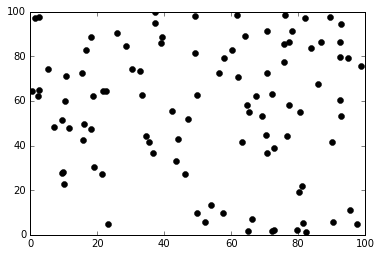

In [11]:
plt.plot(rand_points[:,0], rand_points[:,1], 'ko')
plt.show()

In [12]:
vor_r = Voronoi(rand_points)
#vor_r.vertices


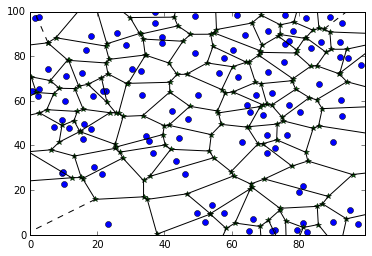

In [13]:
plot_voronoi(rand_points, vor_r)


As Amit notes, a strictly random distribution makes for irregular polygon shapes
and sizes. What one wants is semi-random "blue noise", which Amit approximates
using Lloyd Relaxation. Easiest way to do that in 2D is calculate the [centroid](https://en.wikipedia.org/wiki/Centroid#Centroid_of_polygon) of each polygon.


In [79]:
def centroid(vertices):
    x = vertices[:, 0]
    y = vertices[:, 1]
    c_x, c_y, a = 0., 0., 0.
    for i in range(len(vertices)-1):
        c_x += (x[i] + x[i+1])*(x[i]*y[i+1] - x[i+1]*y[i])
        c_y += (y[i] + y[i+1])*(x[i]*y[i+1] - x[i+1]*y[1])
        a += x[i]*y[i+1] - x[i+1]*y[i]
    
    return np.asarray([c_x/(3*a), c_y/(3*a)])

This works, but not so well with infinite points (i.e. the -1 indices), so the
solution is to calculate where the infinite lines intersection with the edges of
the map.

The below is borrowed from [stackoverflow](http://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect).



In [14]:
def line_line_intersection(p0, p1, p2, p3):
    s1 = p1 - p0
    s2 = p3 - p2
    i = np.zeros([2])

    s = (-s1[1]*(p0[0] - p2[0]) + s1[0] * (p0[1] - p2[1])) / (-s2[0] * s1[1] + s1[0] * s2[1])
    t = (s2[0] * (p0[1] - p2[1]) - s2[1] * (p0[0] - p2[0])) / (-s2[0] * s1[1] + s1[0] * s2[1])

    if ( 0 <= s <= 1) and (0 <= t <= 1):
        return p0 + t*ss1
    else:
        return None
        

We want to look at the voronoi ridges, i.e. what bounds the finit voronoi regions.

`ridge_points` are in

In [0]:
def far_point_line(vor, idx):
    ridge_points = vor.ridge_points[idx]
    ridge_vertices = vor.ridge_vertices[idx]
    p = vor.points
    center = points.mean(axis=0)
    ridge_vertices = np.asarray(ridge_vertices)
    if np.any(ridge_vertices < 0):
        i = ridge_vertices[ridge_vertices >= 0][0]
        t = p[ridge_points[1]] - p[ridge_points[0]] # tangent
        t /= np.linalg.norm(t)
        n = np.array([-t[1], t[0]]) # Normal
        midpoint = p[ridge_points].mean(axis=0)
        far_point = vor.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
        return vor.vertices[i], far_point
    else:
        return None

In [17]:
vor_r.ridge_points

array([[54, 38],
       [54, 71],
       [54, 21],
       [54,  0],
       [54, 18],
       [67, 92],
       [67, 21],
       [67, 18],
       [24,  8],
       [24, 74],
       [24, 58],
       [24,  4],
       [24, 99],
       [74,  9],
       [74, 61],
       [74,  8],
       [74, 25],
       [74, 86],
       [74, 99],
       [64, 92],
       [64, 21],
       [64, 91],
       [64, 95],
       [64, 11],
       [71,  9],
       [71, 21],
       [71, 20],
       [71, 11],
       [21, 18],
       [21, 92],
       [21, 11],
       [18,  0],
       [18, 92],
       [18, 79],
       [18, 12],
       [87, 79],
       [87, 78],
       [87, 90],
       [87, 38],
       [87,  0],
       [38,  0],
       [38, 16],
       [38, 97],
       [38, 90],
       [ 0, 79],
       [81, 94],
       [81, 41],
       [81, 86],
       [81, 84],
       [81, 70],
       [81, 16],
       [86, 41],
       [86,  8],
       [86, 70],
       [70, 16],
       [ 4, 58],
       [ 4, 99],
       [ 4, 30],
       [ 4, 26

In [13]:
len(vor_r.vertices)

190

In [102]:
polygon = np.asarray([vor_r.vertices[i] for i in vor_r.regions[0]])

In [103]:
polygon

array([[  89.68982438,   87.59497274],
       [ 106.65252408,   88.63239391],
       [  95.80753792,   15.6799995 ],
       [  82.78669572,  163.37578307]])

In [104]:
centroid(polygon)

array([ 49.3579211 ,  27.81584586])

In [123]:
def poly_verts(region):
    return [vor_r.vertices[i] for i in region]

In [124]:
all_polys = [poly_verts(r) for r in vor_r.regions]

relaxed = [centroid(np.asarray(poly)) for poly in all_polys]

IndexError: too many indices for array